In [19]:
folder_path = '/Users/priyankapalaniselvam/Downloads/a_new_dataset/cataract_data'


In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


In [11]:
IMAGE_SIZE = (600, 600)  
BATCH_SIZE = 32

In [12]:
rescale = layers.Rescaling(1./127.5, offset=-1)

In [13]:

class_names = ['cataract', 'normal']


In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    class_names=class_names  
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))


Found 2112 files belonging to 2 classes.
Using 1690 files for training.


In [29]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    class_names=class_names 
)

validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))


Found 2112 files belonging to 2 classes.
Using 422 files for validation.


In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=folder_path,  
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode='categorical',  
    class_names=class_names,  
    shuffle=False,  
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))

print("Training, validation, and test datasets loaded and preprocessed.")

Found 2112 files belonging to 2 classes.
Training, validation, and test datasets loaded and preprocessed.


In [24]:

print("Shape of the first image in the training dataset:", next(iter(train_ds))[0][0].shape)
print("Shape of the first image in the validation dataset:", next(iter(validation_ds))[0][0].shape)
print("Shape of the first image in the test dataset:", next(iter(test_ds))[0][0].shape)

min_pixel_value = float('inf')
max_pixel_value = float('-inf')

for images, _ in train_ds:
    batch_min = tf.reduce_min(images)
    batch_max = tf.reduce_max(images)
    min_pixel_value = tf.minimum(min_pixel_value, batch_min)
    max_pixel_value = tf.maximum(max_pixel_value, batch_max)

print("Minimum pixel value:", min_pixel_value.numpy())
print("Maximum pixel value:", max_pixel_value.numpy())


Shape of the first image in the training dataset: (600, 600, 3)
Shape of the first image in the validation dataset: (600, 600, 3)
Shape of the first image in the test dataset: (600, 600, 3)
Minimum pixel value: -1.0
Maximum pixel value: 1.0


2024-10-28 19:05:12.874869: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


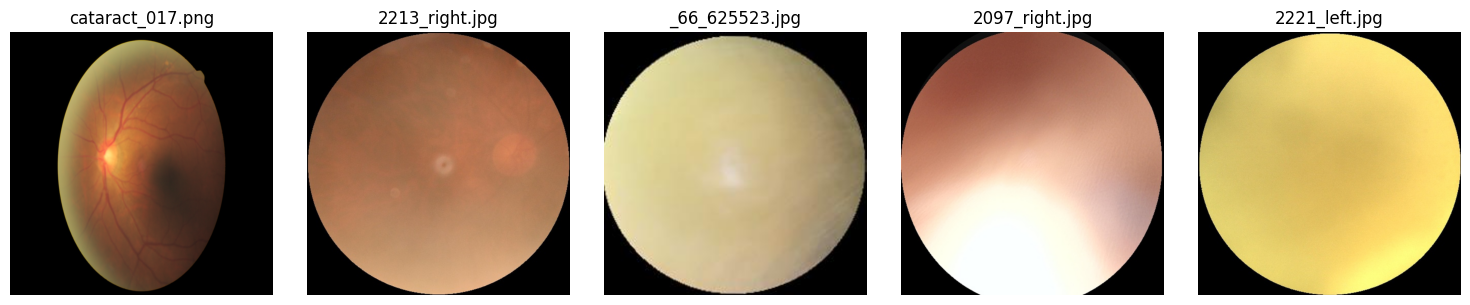

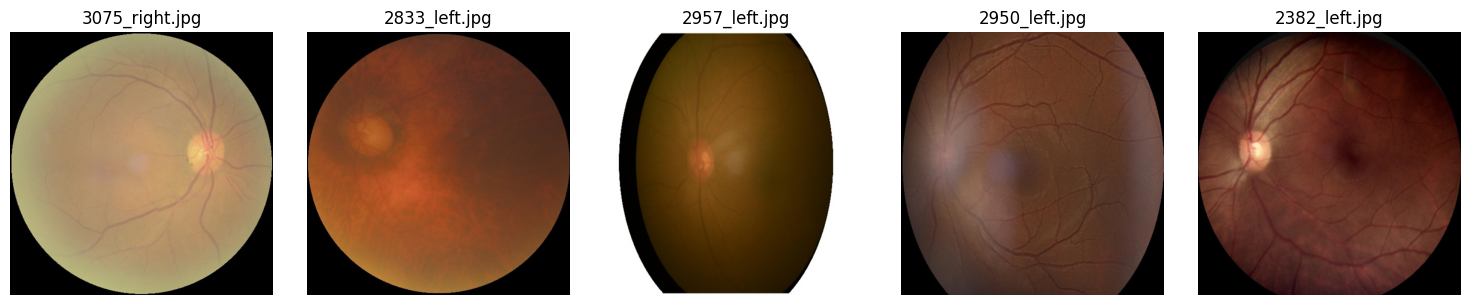

In [26]:


def visualize_images(path, target_size=(600, 600), num_images=5):
    import matplotlib.pyplot as plt
    from PIL import Image

    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        img = Image.open(image_path)
        img = img.resize(target_size)

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    plt.tight_layout()
    plt.show()

path_to_visualize_cataract = '/Users/priyankapalaniselvam/Downloads/a_new_dataset/cataract_data/cataract'
path_to_visualize_normal = '/Users/priyankapalaniselvam/Downloads/a_new_dataset/cataract_data/normal'

visualize_images(path_to_visualize_cataract, target_size=IMAGE_SIZE, num_images=5)

visualize_images(path_to_visualize_normal, target_size=IMAGE_SIZE, num_images=5)



In [27]:
base_model = tf.keras.applications.EfficientNetB7(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  
])

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)



258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [28]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1417s 27s/step - accuracy: 0.5148 - loss: 0.7500 - val_accuracy: 0.5071 - val_loss: 0.6944
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1578s 30s/step - accuracy: 0.4898 - loss: 0.7028 - val_accuracy: 0.4929 - val_loss: 0.6935
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4158s 79s/step - accuracy: 0.5099 - loss: 0.6960 - val_accuracy: 0.4929 - val_loss: 0.6959
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16060s 307s/step - accuracy: 0.4955 - loss: 0.6954 - val_accuracy: 0.4929 - val_loss: 0.6932
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6664s 126s/step - accuracy: 0.5205 - loss: 0.6931 - val_accuracy: 0.4929 - val_loss: 0.6935
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5702s 108s/step - accuracy: 0.5110 - loss: 0.6931 - val_accuracy: 0.4929 - val_loss: 0.6941
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5075s 96s/step - accuracy: 0.5231 - loss: 0.6921 - val_accuracy: 0.4929 - val_loss: 0.6938
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4507s 85s/step - accuracy: 0.5133 - loss: 0.6929 - val_